# Build Magnetic Skeleton

This notebook builds the magnetic skeleton of the active region in question.

In [149]:
import pathlib

from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize
import sunpy.map
from sunpy.net import attrs as a, Fido
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

import greensfield
from greensfield.util import get_coordinates_above_threshold

import synthesizAR

## Download EUV and LOS Magnetogram Data

First, download EUV and magnetogram data.

In [2]:
aia_euv = a.Instrument.aia & a.AttrOr([a.Wavelength(c) for c in [94,131,171,193,211,335]*u.AA])
hmi_bz = a.Instrument.hmi & a.Physobs.los_magnetic_field
q = Fido.search(
    a.Time('2020-04-28 18:30:00', end='2020-04-28 19:30:00', near='2020-04-28 19:00:00'),
    aia_euv | hmi_bz,
)

In [11]:
q

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2020-04-28 18:59:59.000,2020-04-28 19:00:00.000,SDO,AIA,94.0 .. 94.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64
2020-04-28 18:59:54.000,2020-04-28 18:59:55.000,SDO,AIA,131.0 .. 131.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844
Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size
,,,,Angstrom,,,,,,,Mibyte
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64


In [4]:
files = Fido.fetch(q, path='data/{instrument}')

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

2025-03-31 16:15:46 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=94_1367175638-1367175638 failed to download with exception
Timeout on reading data from socket
2025-03-31 16:15:46 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=131_1367175633-1367175633 failed to download with exception
Timeout on reading data from socket
2025-03-31 16:15:46 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=171_1367175635-1367175635 failed to download with exception
Timeout on reading data from socket
2025-03-31 16:15:46 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia__lev1;compress=rice;record=193_1367175643-1367175643 failed to download with exception
Timeout on reading data from socket
2025-03-31 16:15:46 - parfive - INFO: https://sdo7.nascom.nasa.gov/cgi-bin/drms_export.cgi?series=aia

6/0 files failed to download. Please check `.errors` for details


In [3]:
data_dir = pathlib.Path('data/')
aia_files = sorted((data_dir / 'AIA').glob('*.fits'))
hmi_files = sorted((data_dir / 'HMI').glob('*.fits'))
files = aia_files + hmi_files

In [4]:
files

[PosixPath('data/AIA/aia.lev1.131A_2020_04_28T18_59_54.62Z.image_lev1.fits'),
 PosixPath('data/AIA/aia.lev1.171A_2020_04_28T18_59_57.35Z.image_lev1.fits'),
 PosixPath('data/AIA/aia.lev1.193A_2020_04_28T19_00_04.84Z.image_lev1.fits'),
 PosixPath('data/AIA/aia.lev1.211A_2020_04_28T18_59_57.63Z.image_lev1.fits'),
 PosixPath('data/AIA/aia.lev1.335A_2020_04_28T19_00_00.63Z.image_lev1.fits'),
 PosixPath('data/AIA/aia.lev1.94A_2020_04_28T18_59_59.14Z.image_lev1.fits'),
 PosixPath('data/HMI/hmi.m_45s.2020.04.28_19_00_45_TAI.magnetogram.fits')]

In [5]:
m_aia = sunpy.map.Map(files[1])
m_hmi = sunpy.map.Map(files[-1])

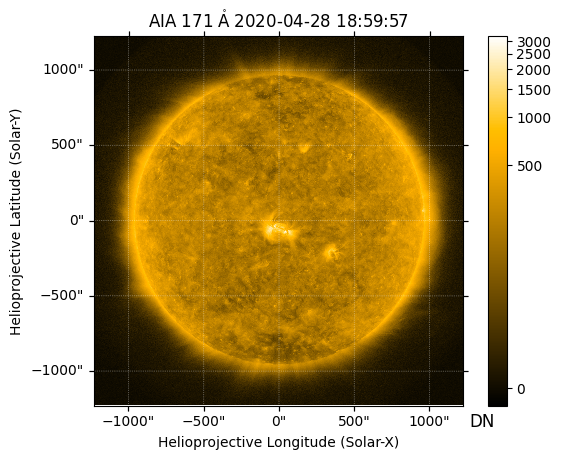

In [6]:
m_aia.peek()

## Select Active Region

Then, create cutout around region.

In [7]:
m_aia_sub = m_aia.submap(
    SkyCoord(Tx=-175*u.arcsec,Ty=-225*u.arcsec,frame=m_aia.coordinate_frame),
    top_right=SkyCoord(Tx=150*u.arcsec,Ty=125*u.arcsec,frame=m_aia.coordinate_frame)
)
tangent_point = SkyCoord(Tx=0*u.arcsec,Ty=-50*u.arcsec,frame=m_aia_sub.coordinate_frame)

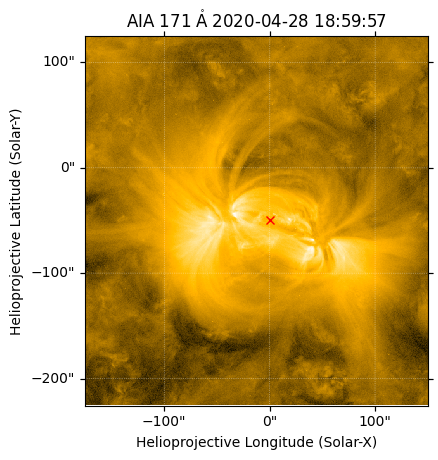

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_sub)
m_aia_sub.plot(axes=ax)
ax.plot_coord(tangent_point, marker='x', color='r')

In [9]:
m_hmi_sub = m_hmi.submap(m_aia_sub.bottom_left_coord,
                         top_right=m_aia_sub.top_right_coord)

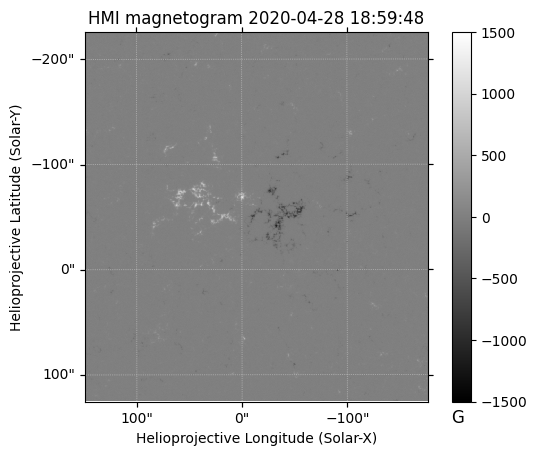

In [10]:
m_hmi_sub.peek(norm=ImageNormalize(vmin=-1500,vmax=1500))

## Extrapolate Potential Field

In [11]:
extrapolator = greensfield.ObliqueSchmidtExtrapolator(
    m_hmi,
    tangent_point,
    [m_aia_sub.bottom_left_coord, m_aia_sub.top_right_coord],
    resample_factor=0.35,
    #scale_z=0.5*u.Mm,
)

2025-07-07 14:08:07 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-07-07 14:08:17 - sunpy - INFO: Apparent body location accounts for 502.42 seconds of light travel time


INFO: Apparent body location accounts for 502.42 seconds of light travel time [sunpy.coordinates.ephemeris]


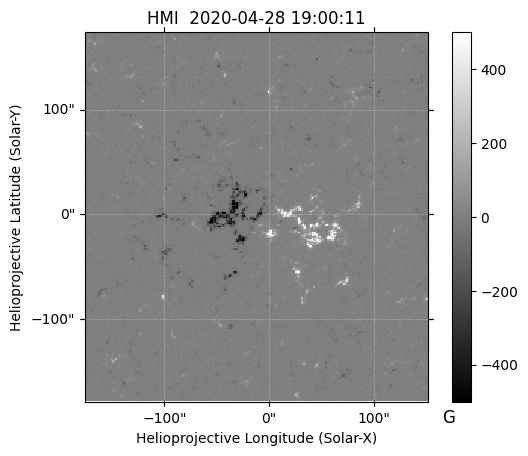

In [12]:
extrapolator.boundary_magnetogram.peek(norm=ImageNormalize(vmin=-500,vmax=500))

Now perform field extrapolation

In [13]:
extrapolator.scale

<Quantity [1.05158561, 1.05158561, 1.05158561] Mm>

In [14]:
extrapolator.shape*extrapolator.scale

<Quantity [238.709934  , 257.63847502, 257.63847502] Mm>

In [15]:
ds = extrapolator.extrapolate()

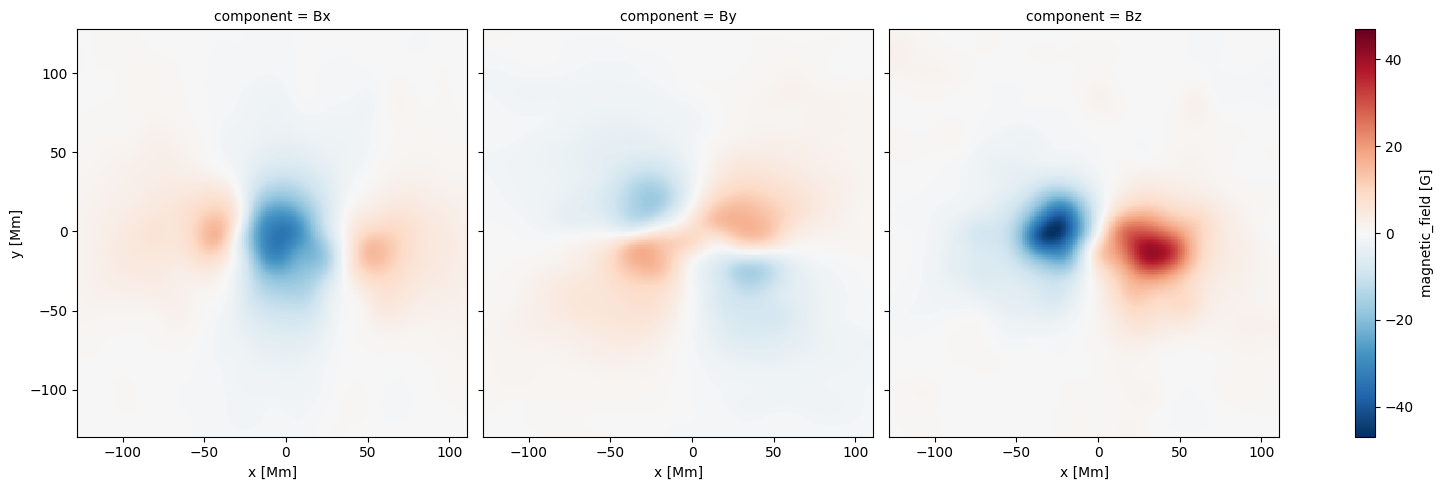

In [16]:
(ds['magnetic_field']
 .sel(z=710, method='nearest')
 .plot
 .imshow(x='x',y='y',col='component',size=5,interpolation='none'))

## Trace Field Lines

In [17]:
m_hmi_boundary_zoom = extrapolator.boundary_magnetogram.submap(
    SkyCoord(Tx=-110*u.arcsec, Ty=-75*u.arcsec, 
             frame=extrapolator.boundary_magnetogram.coordinate_frame),
    top_right=SkyCoord(Tx=30*u.arcsec, Ty=85*u.arcsec,
                       frame=extrapolator.boundary_magnetogram.coordinate_frame)
)
seed_points = get_coordinates_above_threshold(m_hmi_boundary_zoom, -1.5e-2)

In [18]:
len(seed_points)

1391

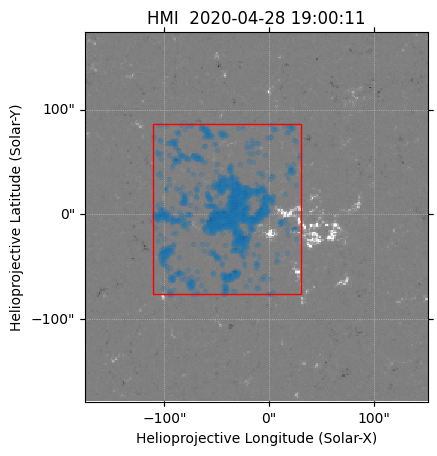

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection=extrapolator.boundary_magnetogram)
extrapolator.boundary_magnetogram.plot(axes=ax,norm=ImageNormalize(vmin=-500,vmax=500))
m_hmi_boundary_zoom.draw_extent(axes=ax,color='r')
ax.plot_coord(seed_points, color='C0', alpha=.2, marker='.', ls='')

In [20]:
fieldlines = extrapolator.trace(
    ds,
    seeds=seed_points,
    step_size=0.1,
)

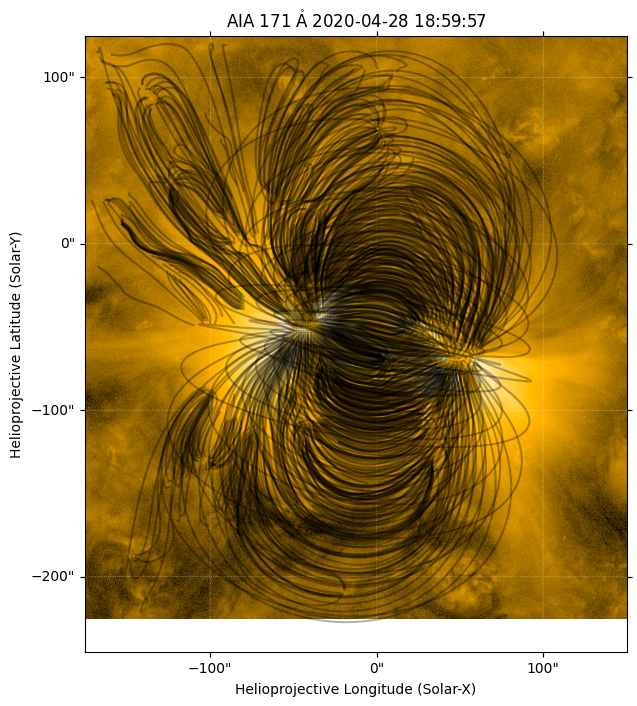

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=m_aia_sub)
m_aia_sub.plot(axes=ax)
for f in fieldlines:
    if f.is_closed and f.length>20*u.Mm and f.length<500*u.Mm:
        #asymm = f.field_strength[0] / f.field_strength[-1]
        #color = 'C3' if asymm < 1 else 'C0'
        color = 'k'
        ax.plot_coord(f.coordinate, color=color, alpha=.3)

## Build Magnetic Skeleton

Do some additional filtering on loop lengths and loops that have connectivity far outside of the active region.

In [30]:
strands = []
for i,f in enumerate(fieldlines):
    if f.is_closed and (20*u.Mm<f.length<500*u.Mm):
        strands.append(synthesizAR.Strand(f'strand{i:06d}', f.coordinate, field_strength=f.field_strength))
skeleton = synthesizAR.Skeleton(strands)

In [376]:
len(skeleton.strands)

983

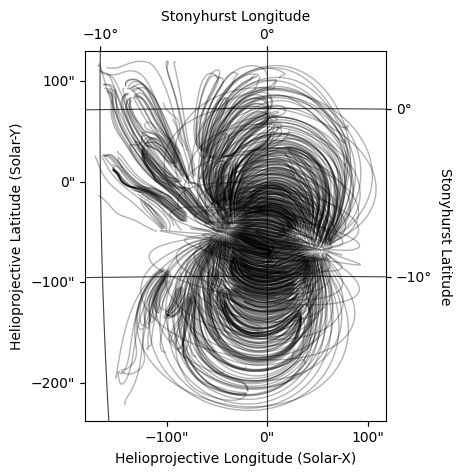

In [35]:
skeleton.peek(observer=m_aia_sub.observer_coordinate, plot_kwargs={'alpha':0.3})

In [377]:
skeleton.to_asdf('data/bare_skeleton.asdf')

## Sandbox

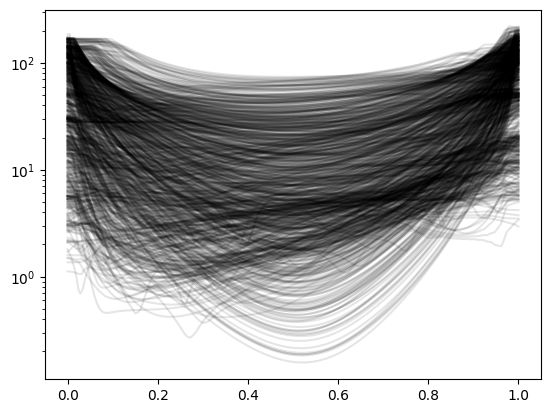

In [70]:
for f in fieldlines:
    if f.is_closed and f.length>20*u.Mm and f.length<500*u.Mm:
        s = np.linspace(0,1,len(f.coordinate))
        plt.plot(s, f.field_strength, color='k',alpha=0.1)
plt.yscale('log')

Text(0, 0.5, '$B_-(s=0)/B_+(s=0)$')

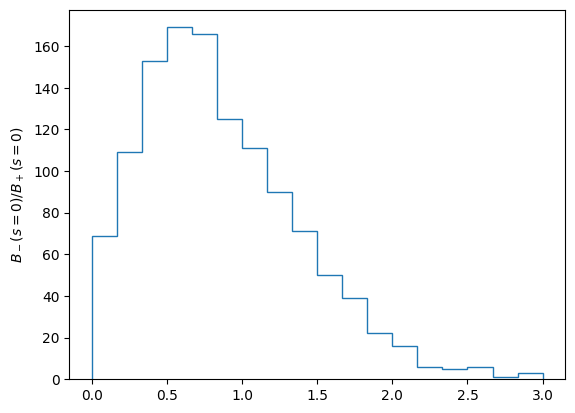

In [93]:
plt.hist(np.array([f.field_strength[0]/f.field_strength[-1] for f in fieldlines if f.is_closed]),
         histtype='step', log=False, bins='scott', range=(0,3));
#plt.xscale('log')
plt.ylabel('$B_-(s=0)/B_+(s=0)$')

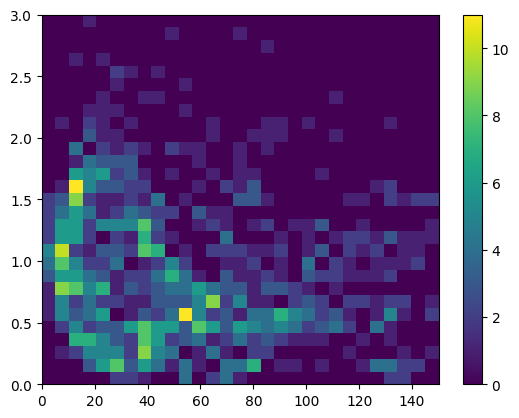

In [132]:
plt.hist2d(
    x=u.Quantity([f.length for f in fieldlines if f.is_closed]).to_value('Mm'),
    y=u.Quantity([f.field_strength[0]/f.field_strength[-1] for f in fieldlines if f.is_closed]).value,
    bins=(np.linspace(0,150,30),np.linspace(0,3,30)),
);
#plt.xscale('log')
#plt.yscale('log')
plt.colorbar()

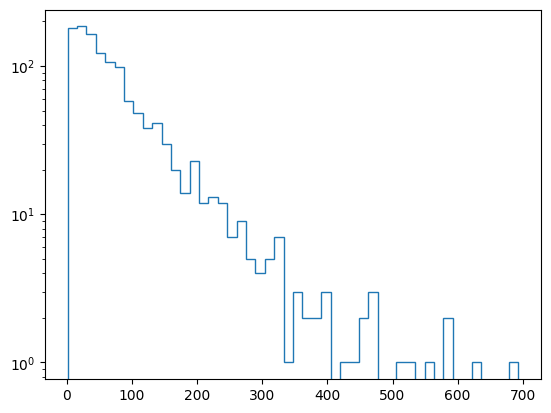

In [61]:
plt.hist(u.Quantity([f.length for f in fieldlines if f.is_closed]).to_value('Mm'), histtype='step', bins='fd', log=True);